In [51]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import numpy
import math
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def read_in_data():
    """
    Reads in our collected BTC csv into a pandas data frame and removes all other columns other than the close price
    
    :param - 
    :returns - Pandas data frame containing the close price indexed by time
    """
    
    data_frame = pd.DataFrame()
    file = "../DataManagement/sentiment_bert.csv"
    data_frame = pd.read_csv(file, names=["Date", "close", "tweets", "negative_score", "positive_score", "neutral_score"])
    data_frame.set_index("Date", inplace = True)
    data_frame = data_frame[["close", "negative_score", "positive_score", "neutral_score"]]     
    return data_frame

In [52]:
def normalize_data(scaler, close_list):
    """
    This section takes in our value lists and scales them using a minmaxscaler within the range 0,1 and reshapes our data.
    We then seperate our data into training and testing sets to a 80:20 split to be used to train and evaluate our model
    
    :param - scaler, close_list
    :returns - train, test
    """
    
    close_list = scaler.fit_transform(np.array(close_list).reshape(-1,1))
    
    train_split = int(len(close_list)*0.80)    
    train = close_list[0:train_split]
    test = close_list[train_split:len(close_list)]
    
    return train, test

In [53]:
def create_train_test_set(data):
    """
    This method takes in either our train or test set and creates a suitable time series sequence where we select
    how many days into the future we want to predict and how many previous days we want to use to make that prediction
    
    :param - data
    :returns - X_train, X_test, y_train, y_test
    """
    
    X = []
    Y = []
    
    future_look_ahead = 1
    previous_days= 5
    for i in range(previous_days, len(data) - future_look_ahead +1):
        X.append(data[i - previous_days:i, 0:data.shape[1]])
        Y.append(data[i + future_look_ahead - 1:i + future_look_ahead, 0])
        
    X, Y = np.array(X), np.array(Y)
    
    return X,Y
    

In [54]:
def create_lstm_model(learning_rate=0.001):
    """
    This method defines the general structure for the regressor that is passed into grid search
    
    :param - 
    :returns - model
    """
    model=Sequential()
    model.add(LSTM(100,return_sequences=True,input_shape=(5,1)))
    #model.add(BatchNormalization())
    model.add(LSTM(64,return_sequences=True))
    model.add(LSTM(32,return_sequences=False))
    model.add(Dense(20))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

def run_grid_search(X_train, y_train):
    """
    This method performs grid search with given parameters on our generic regressor structure
    
    :param - X_train, y_train
    :returns - model
    """    
    grid_parameters = {
        'batch_size' : [2,8,32,64],
        'epochs' : [15,30,60,90],
        'learning_rate':[0.001,0.01,0.0001]
    }
    
    lsmt_model = KerasRegressor(build_fn=create_lstm_model)
    
    grid_results = GridSearchCV(lsmt_model, 
                            param_grid = grid_parameters,
                            scoring = 'neg_mean_squared_error',
                            cv = 2)
    
    grid_results.fit(X_train,y_train)
    return grid_results

In [55]:
def run_optimal_lstm_model(X_train, y_train, X_test, y_test,  optimizer,epochs, batchsize,  learning_rate):
    """
    This method builds and fits our LSTM model to our training data while evaluating score on the test data
    The method then returns our model once it has completed training
    
    :param - X_train, y_train, X_test, y_test, epochs, batchsize, optimizer
    :returns - model
    """
    
    model=Sequential()
    model.add(LSTM(100,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(BatchNormalization())
    model.add(LSTM(64,return_sequences=True))
    model.add(LSTM(32,return_sequences=False))
    model.add(Dense(20))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    
    
    checkpoint_path = "/Saved_model_grid/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True,verbose=1)
    
    
    model.fit(
        X_train, y_train, epochs=epochs, validation_split=0.1, verbose=2, batch_size=batchsize
    )
    
    return model

In [56]:
def forecast_model(df, model, scaler,close_list, X_train, y_train):
    """
    In this method we forecast using our model and the test data set
    We then plot the inverse scaled values onto a graph with the real BTC price
    
    :param - X_train, y_train, X_test, y_test
    :returns - model
    """
    
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    
    forecast_movement = np.concatenate((train_predict,test_predict))
    real_movement = df[["close"]][:294].values

    plt.figure(figsize=(16,8))
    plt.plot(real_movement, color = 'green', label = 'Real Prices')
    plt.plot(forecast_movement,  color = 'purple', label = 'Predicted Prices')
    plt.xlabel('Trades')
    plt.ylabel('Price in USD')
    plt.legend()
    plt.show()

    
    print("MSE:" , math.sqrt(mean_squared_error(real_movement,forecast_movement)))

In [57]:

#Defining our scaler and lookahead values
scaler = MinMaxScaler(feature_range=(0,1))

df = read_in_data()
df = df.iloc[1: , :]
df['close'] = df['close'].astype(float)

close_list = df.reset_index()['close']

In [58]:
train, test = normalize_data(scaler, close_list)
X_train, y_train = create_train_test_set(train)
X_test, y_test = create_train_test_set(test)

X_train.shape

(238, 5, 1)

In [59]:
grid_results = run_grid_search(X_train, y_train)

<ipython-input-54-9fe041d2d468>:32: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lsmt_model = KerasRegressor(build_fn=create_lstm_model)


Epoch 1/15
60/60 [==============================] - 3s 4ms/step - loss: 0.0609 - root_mean_squared_error: 0.2467
Epoch 2/15
60/60 [==============================] - 0s 4ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916
Epoch 3/15
60/60 [==============================] - 0s 4ms/step - loss: 0.0071 - root_mean_squared_error: 0.0843
Epoch 4/15
60/60 [==============================] - 0s 3ms/step - loss: 0.0072 - root_mean_squared_error: 0.0851
Epoch 5/15
60/60 [==============================] - 0s 4ms/step - loss: 0.0079 - root_mean_squared_error: 0.0886
Epoch 6/15
60/60 [==============================] - 0s 3ms/step - loss: 0.0075 - root_mean_squared_error: 0.0865
Epoch 7/15
60/60 [==============================] - 0s 3ms/step - loss: 0.0077 - root_mean_squared_error: 0.0875
Epoch 8/15
60/60 [==============================] - 0s 3ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844
Epoch 9/15
60/60 [==============================] - 0s 3ms/step - loss: 0.0063 - root_mean_squar

In [60]:
print("optimal parameters are:", grid_results.best_params_)
epochs= grid_results.best_params_['epochs']
batchsize= grid_results.best_params_['batch_size']
learning_rate= grid_results.best_params_['learning_rate']
optimizer= 'adam'



best_model = run_optimal_lstm_model(X_train, y_train, X_test, y_test,  optimizer,epochs, batchsize,  learning_rate)

optimal parameters are: {'batch_size': 8, 'epochs': 60, 'learning_rate': 0.01}
Epoch 1/60
27/27 - 3s - loss: 0.0547 - root_mean_squared_error: 0.2340 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535 - 3s/epoch - 127ms/step
Epoch 2/60
27/27 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077 - 106ms/epoch - 4ms/step
Epoch 3/60
27/27 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0644 - 108ms/epoch - 4ms/step
Epoch 4/60
27/27 - 0s - loss: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0518 - 105ms/epoch - 4ms/step
Epoch 5/60
27/27 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0576 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566 - 105ms/epoch - 4ms/step
Epoch 6/60
27/27 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0594 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548 - 103ms/epoch - 4ms/step
Epoc

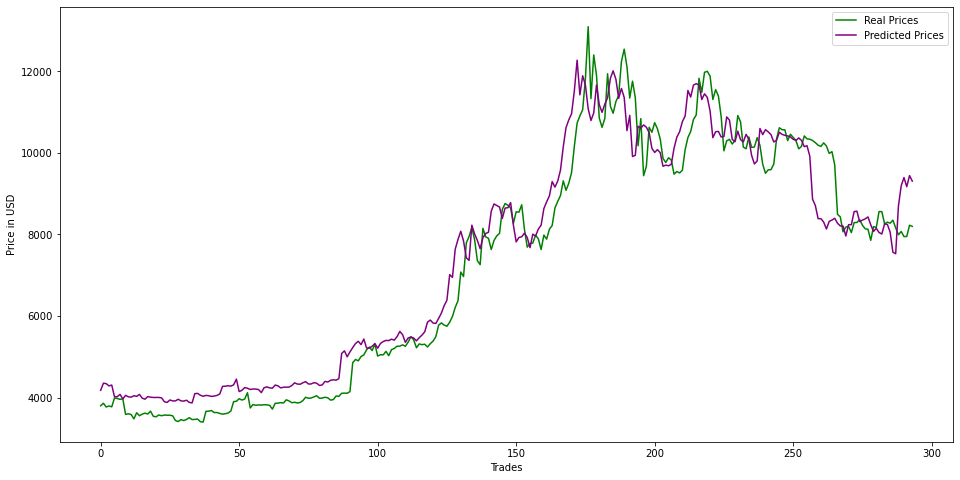

MSE: 669.0250337961184


In [61]:
forecast_model(df, best_model, scaler, close_list, X_train, y_train)